In [43]:
%pip install numpy pandas seaborn matplotlib 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [44]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 24  # Number of steps for payload sizes
run_time_seconds = 30  # Number of seconds to run each test
num_workers = 4 # Number of workers to use for each test

num_users_list = np.array([64])
payload_sizes = np.unique(np.logspace(0, 20, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values


# fix user, small files between 1byte and 100kb
#min_size_log2 = 0  # log2(1 byte)
#max_size_log2 = log(100 * 1024, 2)  # log2(100 KB)
#num_steps_sizes = 32  # Number of steps for payload sizes
#payload_sizes = np.unique(np.logspace(min_size_log2, max_size_log2, num=num_steps_sizes, base=2).astype(int))
#num_users_list = np.full(1, 500)

In [45]:

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


    num_users  spawn_rate  payload_size        csv_filename
0          64          64             1        results_1_64
1          64          64             3        results_3_64
2          64          64             6        results_6_64
3          64          64            11       results_11_64
4          64          64            20       results_20_64
5          64          64            37       results_37_64
6          64          64            67       results_67_64
7          64          64           124      results_124_64
8          64          64           226      results_226_64
9          64          64           414      results_414_64
10         64          64           757      results_757_64
11         64          64          1384     results_1384_64
12         64          64          2528     results_2528_64
13         64          64          4620     results_4620_64
14         64          64          8442     results_8442_64
15         64          64         15425 

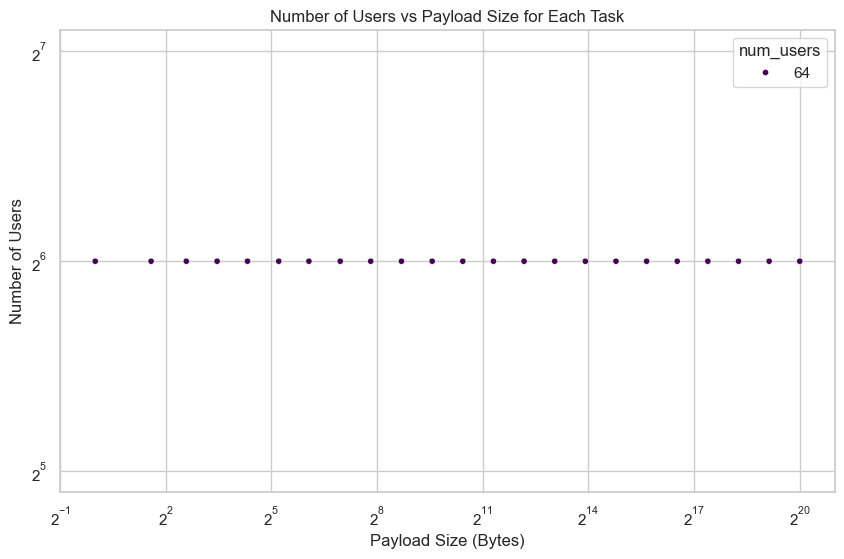

In [46]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='num_users', hue='num_users', palette='viridis', sizes=(20, 200))

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [47]:
def run_benchmark_docker(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f".{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", f"locust-worker={num_workers}"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

#for task in tasks:
#    run_benchmark_docker(task)

In [48]:
def run_benchmark_local(task):
    results_file_path = f".results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Command to start the Locust master
    master_command = ["locust", "-f", "../locust/locustfile.py", "--master", "--headless", 
                      "--expect-workers", "4",
                      "--host", "http://192.168.1.105:8000", 
                      "-u", str(task['num_users']), 
                      "-r", str(task['spawn_rate']), 
                      "--run-time", str(run_time_seconds),
                      "--csv", results_file_path]

    # Commands to start Locust workers
    worker_commands = [
        ["locust", "-f", "../locust/locustfile.py", "--worker", "--master-host", "127.0.0.1"] for _ in range(num_workers)
    ]

    # Start the Locust master
    master_process = subprocess.Popen(master_command)

    # Start the worker processes
    worker_processes = [subprocess.Popen(cmd) for cmd in worker_commands]
    
    try:
        # Wait for the master process to complete
        master_process.wait()
    except KeyboardInterrupt:
        # Handle Ctrl+C
        pass
    finally:
        # Terminate all processes
        master_process.terminate()
        for worker in worker_processes:
            worker.terminate()


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

for task in tasks:
    run_benchmark_local(task)

payload_size: 1payload_size: 1

payload_size: 1payload_size: 1

payload_size: 1


[2023-11-12 23:55:59,298] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:55:59,303] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_732ee93272d246faa10c5e648864760a (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:55:59,303] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 3
payload_size: 3
payload_size: 3
payload_size: 3
payload_size: 3


[2023-11-12 23:56:32,497] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:56:32,499] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_72b1149e727646a9940648cf584cdd42 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:56:32,500] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6


[2023-11-12 23:57:05,654] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 23:57:05,655] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_71f278f32e944ca2b33bd5caae84b115 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:57:05,657] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11


[2023-11-12 23:57:38,810] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:57:38,814] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_b544cfb1102e45da9599d237fe3757ad (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:57:38,814] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20


[2023-11-12 23:58:12,011] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:58:12,015] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_525e745c37ad423b89f945ca0862ad55 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:58:12,016] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37


[2023-11-12 23:58:45,178] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:58:45,182] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_ec56901c6e474085877b1cdce57fcee7 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:58:45,182] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67payload_size: 67



[2023-11-12 23:59:18,330] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:59:18,334] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_f5abda8c8c6048c5aa2b0f9075f0b5b3 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:59:18,335] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124


[2023-11-12 23:59:51,479] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:59:51,482] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_3f6346f038cf408b976cd4595c178808 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:59:51,483] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 226payload_size: 226

payload_size: 226
payload_size: 226
payload_size: 226


[2023-11-13 00:00:24,679] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:00:24,683] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_65e639bf7a764ca9a2e95a6b8e0b0396 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:00:24,683] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414


[2023-11-13 00:00:57,802] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:00:57,806] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_6a13ffbb5fdd4885b4422aee9c071ac4 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:00:57,807] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 757payload_size: 757

payload_size: 757
payload_size: 757
payload_size: 757


[2023-11-13 00:01:31,012] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:01:31,015] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_6462ee01cd544a778df246356a38dabc (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:01:31,015] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 1384payload_size: 1384

payload_size: 1384
payload_size: 1384
payload_size: 1384


[2023-11-13 00:02:04,220] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:02:04,224] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_9b1d0e4357c54c728ebeab733d1284e1 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:02:04,224] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528


[2023-11-13 00:02:37,667] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:02:37,672] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_014af0bde1414ad3abbab2d4241bd041 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:02:37,672] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620


[2023-11-13 00:03:10,848] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:03:10,852] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_bffae46365294beb97f2ddfc7342c874 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:03:10,853] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 8442
payload_size: 8442
payload_size: 8442
payload_size: 8442
payload_size: 8442


[2023-11-13 00:03:44,039] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:03:44,043] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_50de2bea93384bfea60ffc0829fd1461 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:03:44,043] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 15425payload_size: 15425

payload_size: 15425
payload_size: 15425
payload_size: 15425


[2023-11-13 00:04:17,535] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:04:17,539] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_b02982dbc50a43f386b8c705b779df05 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:04:17,539] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 28184payload_size: 28184

payload_size: 28184payload_size: 28184
payload_size: 28184



[2023-11-13 00:04:51,009] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:04:51,014] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_e91fec4073e940c089c3cfd06907c979 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:04:51,014] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 51496
payload_size: 51496
payload_size: 51496
payload_size: 51496
payload_size: 51496


[2023-11-13 00:05:24,188] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:05:24,200] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_0beb5ecf64334bc29fa4b4870bcec31e (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:05:24,200] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 94089payload_size: 94089

payload_size: 94089
payload_size: 94089
payload_size: 94089


[2023-11-13 00:05:57,355] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:05:57,360] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_eb896ca9a7584cddb2b58b4d8dcbafce (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:05:57,360] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911


[2023-11-13 00:06:30,514] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:06:30,518] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_44f823acea3a49d89f56ef203fe4b1d2 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:06:30,518] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 314101payload_size: 314101

payload_size: 314101
payload_size: 314101
payload_size: 314101


[2023-11-13 00:07:03,723] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:07:03,727] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_868069416bd3441cb4da5e1ae686ac94 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:07:03,727] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897


[2023-11-13 00:07:37,012] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:07:37,018] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_c47bb2dd2dd140c09b24913226085dfe (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:07:37,018] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576


[2023-11-13 00:08:10,170] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 00:08:10,175] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_947692b20e2c4c40a54de89682079ea0 (index 0) reported as ready. 1 workers connected.
[2023-11-13 00:08:10,175] BUD-MAC-16300-(26473)/INFO/locust.runne

In [49]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                    "med_response_time": float(agg_row["Median Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


    payload_size  num_users  total_requests  avg_response_time  \
0              1         64            5887         301.081479   
1              3         64            5819         311.354500   
2              6         64            5777         317.095628   
3             11         64            5871         310.634906   
4             20         64            5852         312.069443   
5             37         64            5737         326.124534   
6             67         64            5782         315.670823   
7            124         64            5560         327.016835   
8            226         64            5763         314.368986   
9            414         64            5758         320.501052   
10           757         64            5776         309.212737   
11          1384         64            5792         309.412610   
12          2528         64            5752         317.429481   
13          4620         64            5664         322.119598   
14        

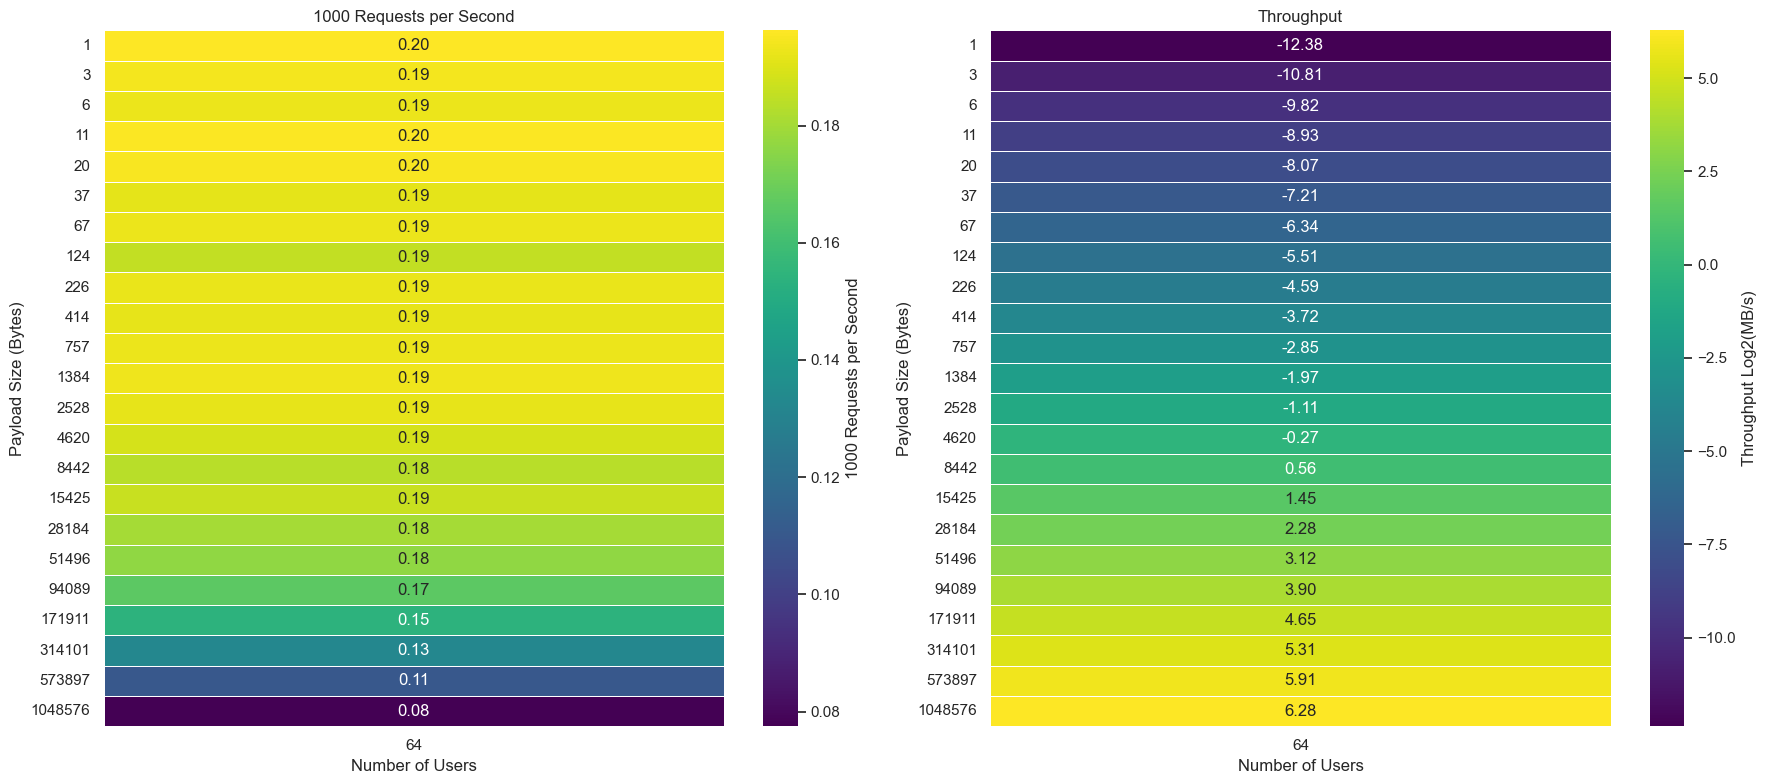

In [50]:
# Add columns for requests per second and requests per second
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds / 1000

#results_df['avg_response_time_per_user'] = results_df['avg_response_time'] / results_df['num_users']
results_df['med_response_time_per_user'] = results_df['med_response_time'] / results_df['num_users']
results_df['throughput'] = results_df['total_requests'] / run_time_seconds * results_df['payload_size'] / 1024 / 1024 # MB/s

# Pivot the DataFrames for the heatmaps
heatmap_data_rps = results_df.pivot(index="payload_size", columns="num_users", values="requests_per_second")
heatmap_data_rt = results_df.pivot(index="payload_size", columns="num_users", values="throughput")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Draw the heatmap for average response time
sns.heatmap(heatmap_data_rps, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "1000 Requests per Second"}, ax=axes[0])
axes[0].set_title('1000 Requests per Second')
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Payload Size (Bytes)')

# Draw the heatmap for requests per second per user
log_heatmap_data = np.log2(heatmap_data_rt + 1e-6)
sns.heatmap(log_heatmap_data, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Throughput Log2(MB/s)"}, ax=axes[1])
axes[1].set_title('Throughput')
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Payload Size (Bytes)')

plt.tight_layout()
plt.show()


In [51]:
print( results_df['num_users'])

0     64
1     64
2     64
3     64
4     64
5     64
6     64
7     64
8     64
9     64
10    64
11    64
12    64
13    64
14    64
15    64
16    64
17    64
18    64
19    64
20    64
21    64
22    64
Name: num_users, dtype: int64


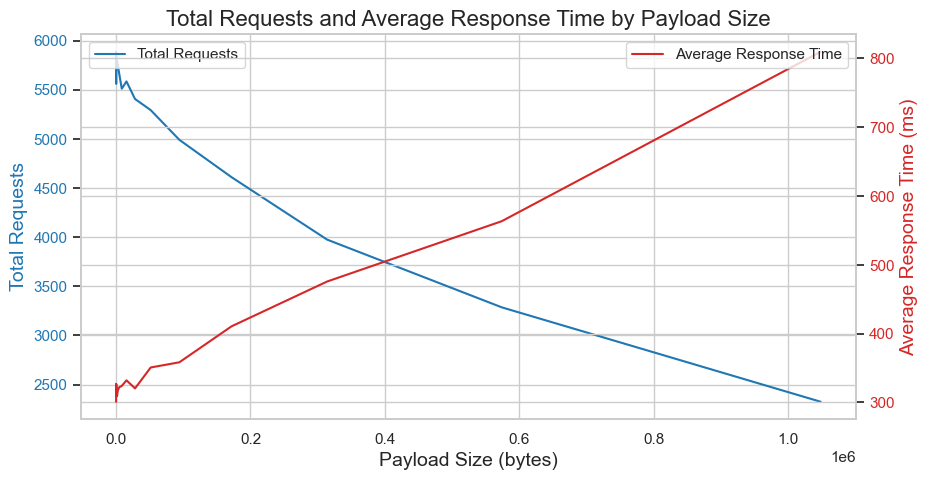

In [52]:
# Assuming 'results_df' is your DataFrame

# First, we will group the data by 'payload_size' and calculate the mean 'total_requests' and 'avg_response_time'.
# This is necessary because your data seems to have multiple entries for each 'payload_size'.
grouped = results_df.groupby('payload_size').mean().reset_index()

# Now let's plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set the x-axis label
ax1.set_xlabel('Payload Size (bytes)', fontsize=14)

# Plot the 'total_requests' on the left y-axis
ax1.set_ylabel('Total Requests', color='tab:blue', fontsize=14)
ax1.plot(grouped['payload_size'], grouped['total_requests'], color='tab:blue', label='Total Requests')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to share the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Average Response Time (ms)', color='tab:red', fontsize=14)  # we already handled the x-label with ax1
ax2.plot(grouped['payload_size'], grouped['avg_response_time'], color='tab:red', label='Average Response Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title of the plot
plt.title('Total Requests and Average Response Time by Payload Size', fontsize=16)

# Show a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()